<br/>
$$ \huge{\underline{\textbf{ Simple Bag of Words }}} $$
<br/>

Contents:

$ \color{red}{TODO} $

# Introduction

This notebook presents very simple Natural-Language-Processing (NLP) neural network using bag-of-words approach.

**Dataset**

We will use subset of _Large Movie Review Dataset_ which is basically 25000 short movie reviews from IMDB along with positive/negative labels.

I originally did this as exercise during [Udacity Deep Learning Nanodegree](https://eu.udacity.com/course/deep-learning-nanodegree--nd101) course. For this purpose Udacity provided easy-to-use version of dataset, where they combined all data into two files labels.txt and reviews.txt, where each line corresponds to separate review (original dataset is a bit more messy).

* Original dataset available here: [http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/)
* Preprocessed version from Udacity: [https://github.com/udacity/deep-learning/tree/master/sentiment-network](https://github.com/udacity/deep-learning/tree/master/sentiment-network)

**Model**

* preprocesssing
  * encode reviews as bag-of-words
* 1st layer: fully connected, no activation
* 2nd layer: fully connected, sigmoid (single output neuron)
* loss: MSE
* optimizer: vanilla SGD

**Dependencies**

* numpy, matplotlib

# Load Data

Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Read text files, each line is one review (or one label). Strip whitespaces, which is mostly removing newline at the end of string.

In [2]:
with open('reviews.txt','r') as f:
    reviews = list(map(str.strip, f.readlines()))
with open('labels.txt','r') as f:
    labels = list(map(str.strip, f.readlines()))

Show example label and review

In [3]:
index = 0
print('LABEL:', labels[index])
print('REVIEW:', reviews[index])

LABEL: positive
REVIEW: bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t


# Explore Dataset

#### Word Count Distribution

First we will look at word-count distribution

In [4]:
counter_all = Counter()  # how many times each word occurs is WHOLE DATASET 
for review, label in zip(reviews, labels):
    for word in review.split():
        counter_all[word] += 1

Lets see how many distinct words we have in our dataset

In [5]:
len(counter_all)

74073

Lets plot it on linear and logarithmic scales

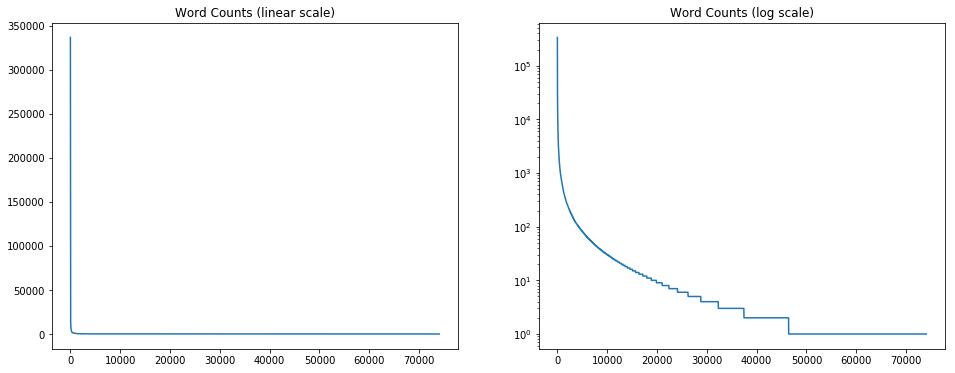

In [6]:
sorted_all = np.array(sorted(list(counter_all.values()), reverse=True))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
ax1.plot(sorted_all); ax1.set_title('Word Counts (linear scale)')
ax2.plot(sorted_all); ax2.set_title('Word Counts (log scale)')
ax2.set_yscale('log')

This is extreemly sharp distribution.

Some words appear over 100k times. Lets have a look at the most common words.

In [7]:
counter_all.most_common()[:10]

[('the', 336713),
 ('.', 327192),
 ('and', 164107),
 ('a', 163009),
 ('of', 145864),
 ('to', 135720),
 ('is', 107328),
 ('br', 101872),
 ('it', 96352),
 ('in', 93968)]

This is potentially a problem, because it is unlikely that words like 'the' or '.' will have much predictive power, they will be as likely to appear in both positive and negative reviews. We might want to remove them in preprocessing stage, but we have to be carful, we don't want to remove words that are both common and have good predictive power! We only want to remove words that are very common, and appear roughly the same amount of time in both positve and negative review. We will look into ratios in next section.

Huge amount of words appear very rarely, over 20k wors appear only once. Lets look at some of these

In [8]:
counter_all.most_common()[-10:]

[('hoodies', 1),
 ('insulation', 1),
 ('mwuhahahaa', 1),
 ('slagged', 1),
 ('bellwood', 1),
 ('pressurized', 1),
 ('malkovitchesque', 1),
 ('muppified', 1),
 ('whelk', 1),
 ('hued', 1)]

I don't think words like 'mwuhahahaa' or 'muppified' or 'whelk' have much predictive power either - this is also a problem, because our neural network will potentially learn to predict based on these words, which will probably hurt generalization.

---

#### Word Ratios Distribution

Another thing to look at is _ratios_ of word occurances in positive/negative reviews. I.e. how much more often word appears in positvie review than in negative review.

In [9]:
counter_pos = Counter()  # how many times each word occurs in NEGATIVE reviews
counter_neg = Counter()  # how many times each word occurs in POSITIVE reviews
for review, label in zip(reviews, labels):
    for word in review.split():
        if label == 'positive':
            counter_pos[word] += 1
        elif label == 'negative':
            counter_neg[word] += 1
        else:
            raise ValueError()

Calculate ratios
* only consider words that appear at least once in both positive and negative review
* discard words that appear less than 50 times in whole dataset for reasons outlined earlier
* reason to take log() is as follows:
  * ratio (without log) is centered around 1 and assymetric
    * word that appears 10-times more often in positive review has ratio 10
    * word that appears 10-times more often in negative reivew has ratio 0.1
    * preferably we would like our ratios to be centered around zero and be symetrical
  * logarithm solves both problems
    * log(0.1) => -10   - for very negative words
    * log(1) => 0       - for neutral words
    * log(10) => 1      - for positve words
    * logarithm is monothonic so it doesn't change ordering

In [10]:
ratios = Counter()
log_ratios = Counter()
for word in counter_all.keys():
    if word in counter_pos and word in counter_neg and counter_all[word] > 100:
        ratios[word] = counter_pos[word] / counter_neg[word]
        log_ratios[word] = np.log(ratios[word])

Plot distributions

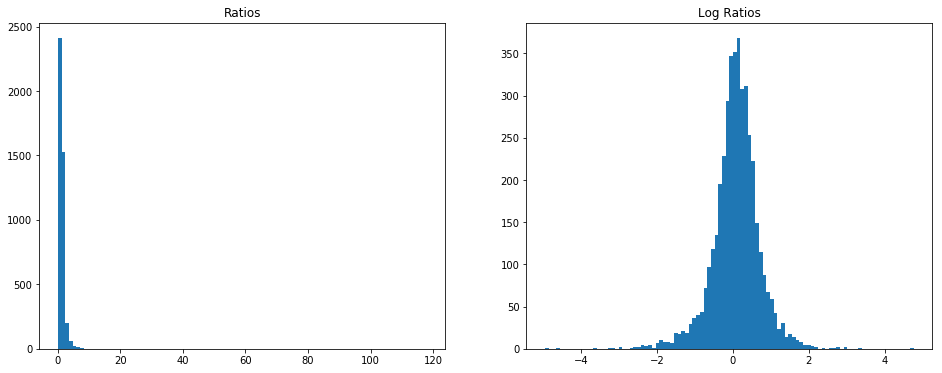

In [11]:
sorted_ratios = np.array(sorted(ratios.values(), reverse=True))
sorted_log_ratios = np.array(sorted(log_ratios.values(), reverse=True))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
ax1.hist(sorted_ratios, bins=100); ax1.set_title('Ratios')
ax2.hist(sorted_log_ratios, bins=100); ax2.set_title('Log Ratios')
plt.show()

I think we can agree that right plot is much more informative of our ratio-distribution.

Lets see words with extreeme values of log-ratios (far on left/right of histogram) and with values most close to zero (middle of histogram)

In [12]:
log_ratios.most_common()[:10]  # highest positve ratio

[('paulie', 4.770684624465665),
 ('felix', 3.3758795736778655),
 ('polanski', 3.005682604407159),
 ('matthau', 2.924504764265623),
 ('victoria', 2.750014400201242),
 ('mildred', 2.7362210780689065),
 ('gandhi', 2.6567569067146595),
 ('flawless', 2.5563656137701454),
 ('superbly', 2.3470368555648795),
 ('perfection', 2.228477120840324)]

In [13]:
log_ratios.most_common()[-10:]  # most negative ratio

[('blah', -2.5649493574615367),
 ('waste', -2.6186484579840514),
 ('unfunny', -2.6882475738060303),
 ('incoherent', -2.929287174145838),
 ('mst', -2.9444389791664407),
 ('stinker', -3.1986731175506815),
 ('unwatchable', -3.248434627109745),
 ('seagal', -3.6375861597263857),
 ('uwe', -4.61512051684126),
 ('boll', -4.962844630259907)]

In [14]:
print(log_ratios['the'])  # these should be close to zero
print(log_ratios['a'])
print(log_ratios['an'])

0.05902881460535952
0.053592687308466704
0.09543414711253344


What we could do in preprocessing is remove words with log-ratios close to zero with some threshold.

# Preprocess Data

In [15]:
review_vocab = set(counter_all.keys())
review_vocab_size = len(review_vocab)
print(review_vocab_size)

74073


Convert labels from 'positive'/'negative' to array of 1s and 0s

In [16]:
targets = np.zeros(shape=[len(labels)])
for idx, label in enumerate(labels):
    if label == 'positive': targets[idx] = 1
    elif label == 'negative': targets[idx] = 0
    else: raise ValueError()

Assign each word a numeric value - actual number doesn't matter as this will be one-hot encoded anyway

In [17]:
word2index = {}
for i, word in enumerate(review_vocab):
    word2index[word] = i

Convert _reviews_ (list of words) to _inputs_ (list of numbers). This is just a simple optimization, so we don't have to repeat this process in the loop later.

In [18]:
def review_to_indices(review):
    res = []
    for word in review.split():
        res.append(word2index[word])
    return np.unique(res)

inputs = []
for review in reviews:
    inputs.append(review_to_indices(review))

In [19]:
print('Review before conversion:')
print(reviews[0])

Review before conversion:
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t


In [20]:
print('Review after conversion:')
print(inputs[0])

Review after conversion:
[  145   862  1385  2044  3232  5239  6017  6130  6617  7186  7284  7538
  9024  9975 10304 10706 13101 13136 13393 14016 15654 16000 17670 19019
 19292 19556 20360 20816 22076 22171 25489 25744 26137 28161 28659 31262
 31398 31805 32201 32237 32366 33414 33837 34278 34750 35876 36740 38234
 38755 39002 39034 40752 42328 42639 43172 46705 47608 48946 49716 50110
 51092 51710 52269 52270 53829 54539 54713 56239 56321 56323 56878 57358
 62046 62221 62867 63183 64307 64638 65199 65953 66454 67911 68407 68963
 70109 71758 71759 71845 72370 72887 72992 73364]


# Model

I will present two versions of this neural network:
* Unoptimised:
  * input is vector of size of vocabular (vector approximately 74073 long if no words were dropped in preprocessing)
    * words that appear in review are encoded as '1'
    * words that do not appear are encoded as '0'
    * e.g. [0, 0, 1, 0, 1, 0, ...]
  * this input vector is very sparse, average review will have maybe 50 words, while vertor is 70k long!
* Optimized:
  * input is short vector of _indices_ where '1' should appear
    * e.g. [13534, 54424, 43256]
  * this input vector is only as long as the amount of words appearing in single review

Key insight is that first layer linear combination is basically multiplying this [0, 0, 1, 0, ...] vector by weight matrix and then summing up. But multiplication by '0' can be dropped, while multiplication by '1' has no effect,  so equivalent operation is to simply pick rows from weight matrix corresponding to '1' and just sum these while ignoring the rest.

Lets have a quick look at unoptimized version

In [21]:
weights = np.array([[0.0, 0.0],
                    [0.1, 1.0],
                    [0.2, 2.0],
                    [0.3, 3.0],
                    [0.4, 4.0]])
input_vector = np.array([0, 0, 1, 0, 1])
matmul_result = input_vector @ weights
print(matmul_result)

[0.6 6. ]


And optimized version:

In [22]:
input_indices = np.array([2, 4])  # indices corresponding to '1' in [0, 0, 1, 0, 1]
matmul_result = np.sum(weights[input_indices], axis=0, keepdims=True)
print(matmul_result)

[[0.6 6. ]]


---

Define sigmoid transfer function

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1-sigmoid(x))

Forward functions, both perform equivalent computation

In [24]:
def forward_vec(xv, Wh, Wo):
    """Params:
        xv - sparse [[0, 0, 1, 0, 1, ...]]
        Wh - weights hidden
        Wo - weights output
    """
    assert xv.ndim == 2
    z_hid = xv @ Wh
    # do not do hidden activation
    z_out = z_hid @ Wo
    y_hat = sigmoid(z_out)
    return y_hat, z_out, z_hid

def forward_idx(xi, Wh, Wo):
    """Params:
        xi - indices [1234, 2345, ...]
    """
    assert xi.ndim == 1
    z_hid = np.sum(Wh[xi], axis=0, keepdims=True)  # <- this is changed
    # do not do hidden activation
    z_out = z_hid @ Wo
    y_hat = sigmoid(z_out)
    
    # Optional: assert optimisation is valid
    # xv = np.zeros([1, len(Wh)])
    # xv[0,xi] = 1
    # z_hid_2 = xv @ Wh
    # assert np.allclose(z_hid, z_hid_2)
    
    return y_hat, z_out, z_hid

Backwad pass

In [25]:
def backward_vec(xv, y, Wh, Wo):
    """Params:
        xv - sparse [[0, 0, 1, 0, 1, ...]]
        y  - target [[0]] for negative or [[1]] for positive
    """
    assert xv.ndim == 2
    assert y.ndim == 2
    y_hat, z_out, z_hid = forward_vec(xv, Wh, Wo)
    ro_out = -(y-y_hat) * sigmoid_deriv(z_out)  # scalar
    del_Wo = np.dot(z_hid.T, ro_out)            # hid_n x 1

    ro_hid = np.dot(ro_out, Wo.T)      # 1 x hid_n
    del_Wh = np.dot(xv.T, ro_hid)      # in_n x hid_n

    return del_Wo, del_Wh, y_hat

def backward_idx(xi, y, Wh, Wo, lr):
    """Params:
        xi - indices [1234, 2345]
    """
    assert xi.ndim == 1
    assert y.ndim == 2
    y_hat, z_out, z_hid = forward_idx(xi, Wh, Wo)
    ro_out = -(y-y_hat) * sigmoid_deriv(z_out)  # scalar
    del_Wo = np.dot(z_hid.T, ro_out)            # hid_n x 1
    
    ro_hid = np.dot(ro_out, Wo.T)      # 1 x hid_n
    Wh[xi] += -lr * ro_hid  # <- optimized version of: del_Wh = np.dot(xv.T, ro_hid)
    
    # Optional: assert optimisation is valid
    # del_Wh = np.zeros_like(Wh)
    # del_Wh[xi] = ro_hid
    # xv = np.zeros([1, len(Wh)])
    # xv[0,xi] = 1
    # del_Wh_2 = np.dot(xv.T, ro_hid)
    # assert np.allclose(del_Wh, del_Wh_2):
    
    return y_hat

Numerical gradient check for testing

In [26]:
def ngrad(xv, y, Wh, Wo):
    """Params:
    xv - sparse vector [0, 0, 1, 0, 1, 0, ...]
    """
    assert xv.ndim == 2
    assert y.ndim == 2
    
    eps = 1e-4
    
    # numerical gradient check output
    ngrad_Wo = np.zeros_like(Wo)
    for r in range(Wo.shape[0]):
        for c in range(Wo.shape[1]):
            W_min = Wo.copy()
            W_pls = Wo.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps

            l_pls = loss(xv, y, Wh, W_pls)
            l_min = loss(xv, y, Wh, W_min)

            ngrad_Wo[r, c] = (l_pls - l_min) / (eps * 2)
    
    # numerical gradient check hidden
    ngrad_Wh = np.zeros_like(Wh)
    _, idx_nonzero = np.nonzero(xv)
    for r in idx_nonzero: #range(self.weights_0_1.shape[0]):
        for c in range(Wh.shape[1]):
            if r % 1000 == 0: print(r)
            W_min = Wh.copy()
            W_pls = Wh.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps

            l_pls = loss(xv, y, W_pls, Wo)
            l_min = loss(xv, y, W_min, Wo)

            ngrad_Wh[r, c] = (l_pls - l_min) / (eps * 2)
            
    return ngrad_Wo, ngrad_Wh      

Loss

In [27]:
def loss(xv, y, Wh, Wo):
    y_hat, z_out, z_hid = forward_vec(xv, Wh, Wo)
    return .5 * np.mean((y-y_hat)**2)

# Train Estimator

Hyperparameters

In [28]:
N_in = len(review_vocab)
N_hid = 10
N_out = 1
lr = 0.1

Initialize

In [29]:
def reset_nn():
    global W_hid, W_out
    np.random.seed(1)
    W_hid = np.random.normal(0, N_in**-.5, [N_in, N_hid])
    W_out = np.random.normal(0, N_hid**-.5, [N_hid, N_out])

Test function

In [30]:
def test(inputs, targets, Wh, Wo, optimize):
    assert len(inputs) == len(targets)
    
    nb_correct = 0
    nb_positive = 0
    
    # loop over given data, note that we don't do mini-batching here
    # there is no particular reason why not do mini-batches
    for i in range(len(inputs)):

        xi = inputs[i]                 # single review, string
        y = np.array([[targets[i]]])   # single target scalar

        if optimize:
            y_hat, _, _ = forward_idx(xi, Wh, Wo)    # fast version
        else:
            xv = np.zeros([1, len(Wh)])              # slow version
            xv[0,xi] = 1
            y_hat, _, _ = forward_vec(xv, Wh, Wo)
        
        if np.abs(y-y_hat) < 0.5:
            nb_correct += 1
        if y_hat > 0.5:
            nb_positive += 1

    print('Nb Positive:', nb_positive)
    print('Nb Correct: ', nb_correct)
    print('Nb Tested:  ', len(inputs))
    print('Accuracy:   ', nb_correct*100 / len(inputs), '%')

Train Function

In [31]:
def train(inputs, targets, Wh, Wo, lr, optimize=False):
    assert len(inputs) == len(targets)
    
    nb_correct = 0
    nb_positive = 0

    start_time = time.time()

    # loop over given data, note that we don't do mini-batching here
    # there is no particular reason why not do mini-batches
    for i in range(len(inputs)):

        xi = inputs[i]                 # single review, string
        y = np.array([[targets[i]]])   # single target scalar

        if optimize:
            y_hat = backward_idx(xi, y, Wh, Wo, lr)
        else:
            xv = np.zeros([1, len(Wh)])           
            xv[0,xi] = 1
            del_Wo, del_Wh, y_hat = backward_vec(xv, y, Wh, Wo)
            y_hat = np.asscalar(y_hat)

#             # Optional: numerical gradient check
#             ngrad_Wo, ngrad_Wh = ngrad(xv, y, Wh, Wo)
#             if not np.allclose(del_Wo, ngrad_Wo):
#                 raise ValueError('Gradient check fail output')
#             if not np.allclose(del_Wh, ngrad_Wh):
#                 raise ValueError('Gradient check fail hidden')
#             print('ngrad OK')

            Wh += -lr * del_Wh
            Wo += -lr * del_Wo
        
        if np.abs(y-y_hat) < 0.5:
            nb_correct += 1
        if y_hat > 0.5:
            nb_positive += 1
            
        if i % 2500 == 0 or i == len(inputs)-1:
            
            timespan = time.time() - start_time
            rev_per_sec = i / timespan
            
            print('Progress:', round(100 * i/len(inputs), 0),
                  'Speed(rev/sec):', round(rev_per_sec, 0),
                  'Correct:', nb_correct, 'Trained:', i,
                  'Accuracy:', round(nb_correct * 100 / (i+1), 6), '%')

Test uninitialized network, this should be close to 50% accuracy

In [32]:
reset_nn()
test(inputs[-1000:], targets[-1000:], W_hid, W_out, optimize=True)

Nb Positive: 768
Nb Correct:  494
Nb Tested:   1000
Accuracy:    49.4 %


Train from scratch

In [33]:
reset_nn()
train(inputs[:-1000], targets[:-1000], W_hid, W_out, lr, optimize=True)

Progress: 0.0 Speed(rev/sec): 0.0 Correct: 1 Trained: 0 Accuracy: 100.0 %
Progress: 10.0 Speed(rev/sec): 11738.0 Correct: 1965 Trained: 2500 Accuracy: 78.568573 %
Progress: 21.0 Speed(rev/sec): 11676.0 Correct: 4016 Trained: 5000 Accuracy: 80.303939 %
Progress: 31.0 Speed(rev/sec): 11401.0 Correct: 6139 Trained: 7500 Accuracy: 81.842421 %
Progress: 42.0 Speed(rev/sec): 11534.0 Correct: 8295 Trained: 10000 Accuracy: 82.941706 %
Progress: 52.0 Speed(rev/sec): 11603.0 Correct: 10457 Trained: 12500 Accuracy: 83.649308 %
Progress: 62.0 Speed(rev/sec): 11505.0 Correct: 12597 Trained: 15000 Accuracy: 83.974402 %
Progress: 73.0 Speed(rev/sec): 11488.0 Correct: 14709 Trained: 17500 Accuracy: 84.046626 %
Progress: 83.0 Speed(rev/sec): 11509.0 Correct: 16880 Trained: 20000 Accuracy: 84.39578 %
Progress: 94.0 Speed(rev/sec): 11455.0 Correct: 19061 Trained: 22500 Accuracy: 84.711791 %
Progress: 100.0 Speed(rev/sec): 11443.0 Correct: 20381 Trained: 23999 Accuracy: 84.920833 %


In [34]:
test(inputs[-1000:], targets[-1000:], W_hid, W_out, optimize=True)

Nb Positive: 531
Nb Correct:  857
Nb Tested:   1000
Accuracy:    85.7 %


---

For comparison, train w/o optimization

In [35]:
reset_nn()
train(inputs[:-1000], targets[:-1000], W_hid, W_out, lr, optimize=False)

Progress: 0.0 Speed(rev/sec): 0.0 Correct: 1 Trained: 0 Accuracy: 100.0 %
Progress: 10.0 Speed(rev/sec): 246.0 Correct: 1956 Trained: 2500 Accuracy: 78.208717 %
Progress: 21.0 Speed(rev/sec): 256.0 Correct: 4001 Trained: 5000 Accuracy: 80.003999 %
Progress: 31.0 Speed(rev/sec): 258.0 Correct: 6129 Trained: 7500 Accuracy: 81.709105 %
Progress: 42.0 Speed(rev/sec): 253.0 Correct: 8286 Trained: 10000 Accuracy: 82.851715 %
Progress: 52.0 Speed(rev/sec): 254.0 Correct: 10441 Trained: 12500 Accuracy: 83.521318 %
Progress: 62.0 Speed(rev/sec): 256.0 Correct: 12584 Trained: 15000 Accuracy: 83.887741 %
Progress: 73.0 Speed(rev/sec): 257.0 Correct: 14699 Trained: 17500 Accuracy: 83.989486 %
Progress: 83.0 Speed(rev/sec): 259.0 Correct: 16872 Trained: 20000 Accuracy: 84.355782 %
Progress: 94.0 Speed(rev/sec): 260.0 Correct: 19059 Trained: 22500 Accuracy: 84.702902 %
Progress: 100.0 Speed(rev/sec): 260.0 Correct: 20381 Trained: 23999 Accuracy: 84.920833 %


In [36]:
test(inputs[-1000:], targets[-1000:], W_hid, W_out, optimize=False)

Nb Positive: 531
Nb Correct:  861
Nb Tested:   1000
Accuracy:    86.1 %
